In [1]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [2]:
using Pkg

pkg"add Plots"

pkg"precompile"

using Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed RecipesBase ──────── v0.7.0
 Installed NaNMath ──────────── v0.3.2
 Installed ColorTypes ───────── v0.8.0
 Installed Requires ─────────── v0.5.2
 Installed Plots ────────────── v0.27.0
 Installed Contour ──────────── v0.5.1
 Installed DataStructures ───── v0.17.5
 Installed GR ───────────────── v0.42.0
 Installed Reexport ─────────── v0.2.0
 Installed Showoff ──────────── v0.3.1
 Installed DataAPI ──────────── v1.1.0
 Installed FixedPointNumbers ── v0.6.1
 Installed PlotUtils ────────── v0.6.1
 Installed GeometryTypes ────── v0.7.6
 Installed Colors ───────────── v0.9.6
 Installed StatsBase ────────── v0.32.0
 Installed StaticArrays ─────── v0.12.1
 Installed PlotThemes ───────── v0.4.0
 Installed SortingAlgorithms ── v0.3.1
 Installed FFMPEG ───────────── v0.2.3
 Installed Missings ─────────── v0.4.3
 Installed OrderedColle

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


# Recurrent neural networks #

It is time for our first “advanced” architecture!

## Early intermission: Assignment 1 postmortem and regarding Assignments 2 and 3 ##

Reflections on my part:

Bad:

1. Issues with wording, a learning process.
2. Why did I enforce Julia? I actually do not know…

Good:

1. Given the feedback I have received, working with “real” data was a useful exercise.
2. The difficulty level seems to have been correct, but more on this shortly…

Questions for the students:

1. Difficulty, too easy? Too difficult?
2. Sufficient amount of time?
3. Did you feel that you learned something?
4. Did the five separate sub-assignments make distributing the work easier?
5. How did you find the compute situation, were the models too heavy?
6. Did you perform the work in notebooks or did you set up a local installation?
7. How did you find support related to Julia?
8. In general, what worked well?
9. Also in general, what did not work well?

Actions for Assignment 2 (what I have so far):

1. Allow for anything that runs in a Colaboratory notebook, no need to enforce Julia.
2. Take extra care when it comes to wording.

* Any suggestions on your part?
* Assignment 2 due to be released this Thursday, when shall we have the deadline?

## End of intermission: The problem of variable length inputs ##

So far all of the inputs to our neural networks have been “fixed size”, in that each $x$ has had the same dimensionality. But this is not always the case:

* Language: Not all sentences have the same length
* Time series: Varying history length

There is also the issue of images of different sizes, but let us ignore that for now…

## The “vanilla” Recurrent Neural Network ##

Conceptually we can think of a Recurrent Neural Network (RNN) as a state machine that takes its previous output $h_{t - 1}$, an input at a given time $t$, $x_t$, and produces an output $h_t$. Early in the literature they were illustrated precisely like a state machine, see the illustration below.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png)

[Image source](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

$$ h_t = \textrm{tanh}(W[h_{t - 1}, x_t]) $$

$$ W \in \mathbb{R}^{d \times 2d} $$



However, these while these illustrations are simple and compact, it is easier to “unroll” an RNN when discussing its behaviour. Exactly as we can see below.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

[Image source](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

This is a very powerful model, even proven to be Turing complete.

### Activation function reminder ###

Just to refresh our memory, here are the two activations functions we will use throughout today’s lecture.

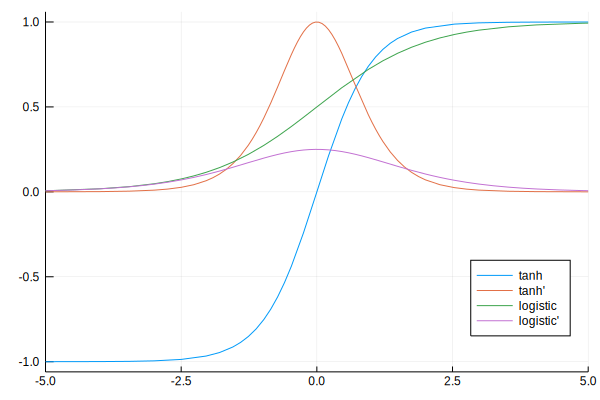

In [0]:
tanhprime(x)     = 1 .- tanh(x).^2
plt = plot(tanh, xlimits=(-5, 5), label="tanh", legend=:bottomright)
plt = plot!(plt, tanhprime, label="tanh'")
logistic(x)      = 1/(1 .+ exp.(-x))
logisticprime(x) = logistic(x).*(1 .- logistic(x))
plt = plot!(plt, logistic, label="logistic")
plot!(plt, logisticprime, label="logistic'")

### Exploding gradient ###

We note the $\textrm{tanh}$ activation function being used for our “vanilla” RNN. Why is it necessary? Given the term “exploding gradient” what do you believe it signifies? When it is a problem?

### Vanishing gradient ###

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-shorttermdepdencies.png)

Imagine that an output $h_3$ is to be influenced by observations $x_0$ and $x_1$, this is exactly the kind of behaviour we expect an RNN to be able to learn.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-longtermdependencies.png)

However, by virtue of the inner workings of the “vanilla” RNN. As the distance between an output and its related inputs increase, it becomes more difficult to learn the desired behaviour, sometimes even impossible. *Why?*

### Long Short-Term Memory ###

The problem of vanishing gradients plagued the field througouht the 90s, but unlike the vanishing gradient for multi-layer perceptrons which we only came to terms with in the late 00s, [Hochreiter and Schmidhuber (1997)](https://www.bioinf.jku.at/publications/older/2604.pdf) proposed a fairly ingenious solution to the problem – Long Short-Term Memory, commonly referred to as an LSTM.

Consider our “vanilla” RNN.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

$$ h_t = \textrm{tanh}(W[h_{t - 1}, x_t]) $$

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

### The “cell state”, our long-term memory ###

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png)

### Forget gate ###

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

### Input gate ###

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

### Cell state update ###

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

### Output gate ###

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

What are some positive downsides of the LSTM? Does it still suffer from exploding/vanishing gradients or is it immue to these phenomena under all circumstances? In 2016 (or was it 2015?) Google Research published a paper on a minute detail regarding the initialisation of the LSTM weights at ICML. Allegedly Schmidthuber upon seeing the work as a poster presentation commented to the authors that “Oh, yes, we forgot to mention that, didn’t we?”. What do you think this detail was?.


### LSTM variants ###

There is no standard formulation of the LSTM, although what we used above is the most dominant. Here are two alternative formulations. Can we derive their motivations from their equations?

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-peepholes.png)

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-tied.png)

In practice the “simpler” formulation is “powerful enough” and you rarely see these variants.

#### Gated Recurrent Unit (GRU) ####

Introduced by Cho et al. (2014) as a more computationally efficient variant to the LSTM. Again, once you are familiar with the LSTM it becomes fairly straight forward to analyse its behaviour from its equations.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

### So, what does an LSTM learn? ###

In theory, even a “vanilla” RNN is Turing complete ([Siegelmann and Sontag, 1995](http://research.cs.queensu.ca/home/akl/cisc879/papers/SELECTED_PAPERS_FROM_VARIOUS_SOURCES/05070215382317071.pdf)). But at this point, we can draw parallels to how we know that while neural networks are universal function approximators, we do know that ultimately we are limited by what we can learn given finite amounts of data and compute. So, how complex of a behaviour can these models learn?

![](https://d3i71xaburhd42.cloudfront.net/40be3888daa5c2e5af4d36ae22f690bcc8caf600/5-Figure2-1.png)

[Image source](https://www.semanticscholar.org/paper/Visualizing-and-Understanding-Recurrent-Networks-Karpathy-Johnson/40be3888daa5c2e5af4d36ae22f690bcc8caf600)

From [“Visualizing and Understanding Recurrent Networks”](https://arxiv.org/abs/1506.02078) by Karpathy et al. (2015), which is a remarkably accessible paper.

## Structure-guided recurrent neural networks ##

For a brief moment in time, referred to as “recursive neural networks”.

![](https://d3i71xaburhd42.cloudfront.net/0c23ebb3abf584fa5e0fde558584befc94fb5ea2/1-Figure1-1.png)

[Image source](https://www.semanticscholar.org/paper/Parsing-Natural-Scenes-and-Natural-Language-with-Socher-Lin/9c0ddf74f87d154db88d79c640578c1610451eec)

### Sentiment analysis ##

![](https://d3i71xaburhd42.cloudfront.net/961f6d5bb9b43833d7387e377b25d7a68118b23b/3-Figure2-1.png)

[Image source](https://www.semanticscholar.org/paper/Recursive-Deep-Models-for-Semantic-Compositionality-Socher-Perelygin/687bac2d3320083eb4530bf18bb8f8f721477600)

More examples at the [Stanford Sentiment Treebank homepage](https://nlp.stanford.edu/sentiment/treebank.html).

### Syntactic analysis  ###

![](https://upload.wikimedia.org/wikipedia/commons/5/54/Parse_tree_1.jpg)

[Image source](https://en.wikipedia.org/wiki/File:Parse_tree_1.jpg)

![](https://d3i71xaburhd42.cloudfront.net/acc4e56c44771ebf69302a06af51498aeb0a6ac8/1-Figure1-1.png)

![](https://d3i71xaburhd42.cloudfront.net/acc4e56c44771ebf69302a06af51498aeb0a6ac8/9-Figure5-1.png)

[Image source](https://www.semanticscholar.org/paper/Parsing-with-Compositional-Vector-Grammars-Socher-Bauer/acc4e56c44771ebf69302a06af51498aeb0a6ac8)


### 2014 to 2018: RNN variants ###

For a few years, RNNs with LSTM cells dominated the field of natural language processing. Below are two very common examples.

#### Sequence to Sequence RNN ####

![](https://d3i71xaburhd42.cloudfront.net/cd52da21cdec50b25b6fb0ba6741091ad38fc986/2-Figure1-1.png)

#### Bi-directional RNN ####

![](https://d3i71xaburhd42.cloudfront.net/8dd6aae51e31a72752c4be5cddbdd76dfdc6cda4/4-Figure3-1.png)

## Acknowledgements ##

A big thank you to Christopher Olah for his [“Understanding LSTM Networks”](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (2015) from which I myself and many others “steal” the excellent illustrations.